✅ Libraries imported successfully!
✅ Dataset loaded successfully!
Shape: (4240, 16)

📊 Data summary:
               male           age     education  currentSmoker    cigsPerDay  \
count  4.240000e+03  4.240000e+03  4.240000e+03   4.240000e+03  4.240000e+03   
mean  -1.206582e-16  1.202392e-16 -3.435407e-17  -1.005485e-17 -5.362587e-17   
std    1.000118e+00  1.000118e+00  1.000118e+00   1.000118e+00  1.000118e+00   
min   -8.672175e-01 -2.050902e+00 -9.731716e-01  -9.882763e-01 -7.514122e-01   
25%   -8.672175e-01 -8.843035e-01 -9.731716e-01  -9.882763e-01 -7.514122e-01   
50%   -8.672175e-01 -6.768471e-02  1.990844e-02  -9.882763e-01 -7.514122e-01   
75%    1.153113e+00  7.489341e-01  1.012988e+00   1.011863e+00  9.287838e-01   
max    1.153113e+00  2.382172e+00  2.006069e+00   1.011863e+00  5.129274e+00   

             BPMeds  prevalentStroke  prevalentHyp      diabetes  \
count  4.240000e+03     4.240000e+03  4.240000e+03  4.240000e+03   
mean   6.535653e-17     1.005485e-16  6.03

Epoch: 0 | critic_loss: 5.027068614959717 | generator_loss: 0.744175910949707
Epoch: 1 | critic_loss: 2.5146026611328125 | generator_loss: 0.5243115425109863
Epoch: 2 | critic_loss: 0.23568499088287354 | generator_loss: 0.25854843854904175
Epoch: 3 | critic_loss: -0.0037176012992858887 | generator_loss: -0.3115084767341614
Epoch: 4 | critic_loss: 0.0995689257979393 | generator_loss: -0.083484947681427
Epoch: 5 | critic_loss: 0.04417292773723602 | generator_loss: -0.01395881175994873
Epoch: 6 | critic_loss: -0.11860713362693787 | generator_loss: -0.11579209566116333
Epoch: 7 | critic_loss: 0.14801454544067383 | generator_loss: -0.17446231842041016
Epoch: 8 | critic_loss: 0.061086274683475494 | generator_loss: -0.1772911548614502
Epoch: 9 | critic_loss: 0.12225927412509918 | generator_loss: -0.37995004653930664
Epoch: 10 | critic_loss: 0.4164901673793793 | generator_loss: -0.5703139305114746
Epoch: 11 | critic_loss: 0.2543759047985077 | generator_loss: -0.7619473934173584
Epoch: 12 | cri

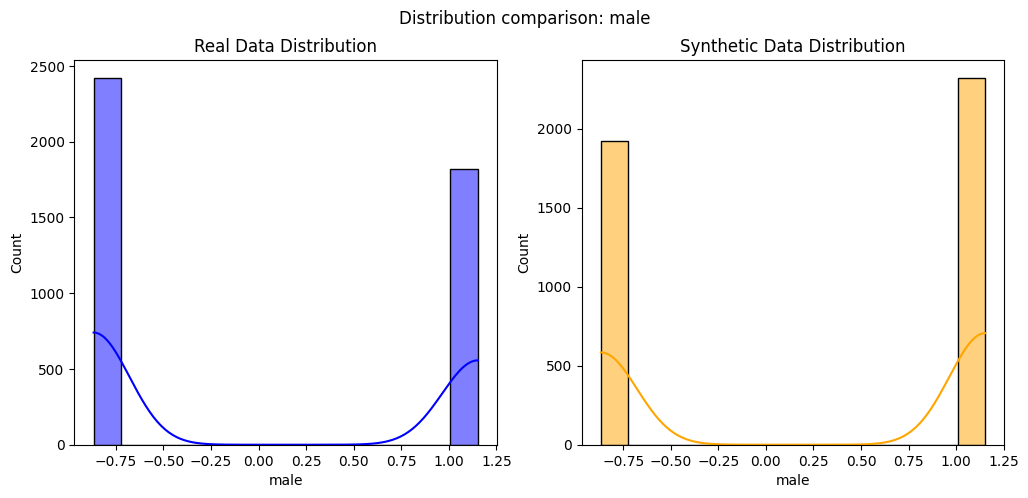

💾 Synthetic dataset saved to ../data/synthetic/framingham_synthetic_ctgan.csv
✅ Synthetic data generation completed successfully!


In [1]:
# === 1. Setup ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers.regular.ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully!")
# === 2. Load the clean dataset ===

file_path = "../data/processed/framingham_clean.csv"
df = pd.read_csv(file_path)

print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

# === 3. Basic data inspection ===

print("\n📊 Data summary:")
print(df.describe())

categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# === 4. Data normalization for CTGAN ===

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

print("✅ Data normalized successfully!")
df_scaled.head()

# Define target and categorical columns
target = "TenYearCHD"
categorical_cols = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 
                    'prevalentHyp', 'diabetes', 'TenYearCHD']


# === 5. Define CTGAN parameters ===

ctgan_args = ModelParameters(batch_size=500, lr=2e-4, betas=(0.5, 0.9))
train_args = TrainParameters(epochs=300)

print("✅ Model and training parameters set up.")

# === 6. Train the CTGAN model ===

# Separiamo le colonne numeriche e categoriali
target = "TenYearCHD"
categorical_cols = ['male', 'currentSmoker', 'BPMeds', 'prevalentStroke', 
                    'prevalentHyp', 'diabetes', 'TenYearCHD']
num_cols = [col for col in df_scaled.columns if col not in categorical_cols + [target]]
cat_cols = categorical_cols

# Inizializza il modello
ctgan = CTGAN(model_parameters=ctgan_args)

# Addestra il modello — tutti gli argomenti in ordine, senza nomi
ctgan.fit(df_scaled, train_args, num_cols, cat_cols)

print("🎯 CTGAN training completed successfully!")




# === 7. Generate synthetic data ===

num_samples = len(df_scaled)
df_synth = ctgan.sample(num_samples)

print(f"✅ Generated synthetic dataset with {df_synth.shape[0]} rows.")
df_synth.head()

# === 8. Reverse scaling for comparison ===

df_synth[numerical_cols] = scaler.inverse_transform(df_synth[numerical_cols])
print("✅ Reversed normalization for synthetic data.")


# === 9. Quick comparison with real data ===

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[numerical_cols[0]], ax=axes[0], kde=True, color='blue')
sns.histplot(df_synth[numerical_cols[0]], ax=axes[1], kde=True, color='orange')

axes[0].set_title("Real Data Distribution")
axes[1].set_title("Synthetic Data Distribution")
plt.suptitle(f"Distribution comparison: {numerical_cols[0]}")
plt.show()

# === 10. Save the synthetic dataset ===

output_path = "../data/synthetic/framingham_synthetic_ctgan.csv"
df_synth.to_csv(output_path, index=False)

print(f"💾 Synthetic dataset saved to {output_path}")
print("✅ Synthetic data generation completed successfully!")